# LEP vs shower time
This is a tricky case.  LEP is often 20 minutes after shower, but only after a certain time (8pm ish?).  Looking for ways to discover this 2D relationship, in a way I can apply to other data.  Visualisations, ML, etc.

In [219]:
import logging

import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd

from importlib import reload

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [220]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [221]:
col1 = 'events:shower:lastSSM'
col2 = 'circadian:combined:entries:LEP:datetimeSSM'
c1 = 'shower'
c2 = 'LEP'

columns_to_select = [col1, col2]

df = day_data.copy()[columns_to_select]
df.index = day_data['dayAndNightOf']
import notebooks.Util.Time as Time
reload(Time)
df = Time.convert_cols_to_hours(df)


df[c1] = df[col1.replace(':lastSSM', ':last')]
df[c2] = df[col2.replace(':datetimeSSM', ':datetime')]
df.drop(columns=[col1.replace(':lastSSM', ':last'), col2.replace(':datetimeSSM', ':datetime')], inplace=True)

# Circadian data just gets better here. As I'm doing morning walks.
df = df[df.index >= '2024-08-14']
df = df[df[c1].notna() & df[c2].notna()]
df['Diff'] = df[c1] - df[c2]


df.head()

,shower,LEP,Diff
dayAndNightOf,,,
2024-08-18,14.766667,22.366667,-7.600000
2024-08-26,15.416667,21.200000,-5.783333
2024-09-15,18.250000,21.400000,-3.150000
2024-09-18,21.166667,21.933333,-0.766667
2024-09-28,18.833333,21.866667,-3.033333


# Simple correlations

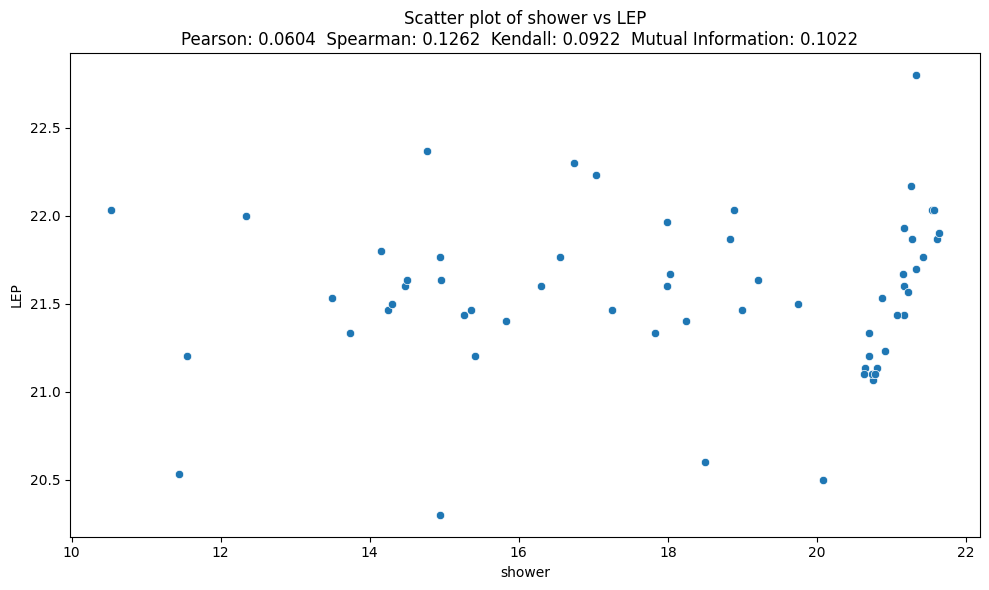

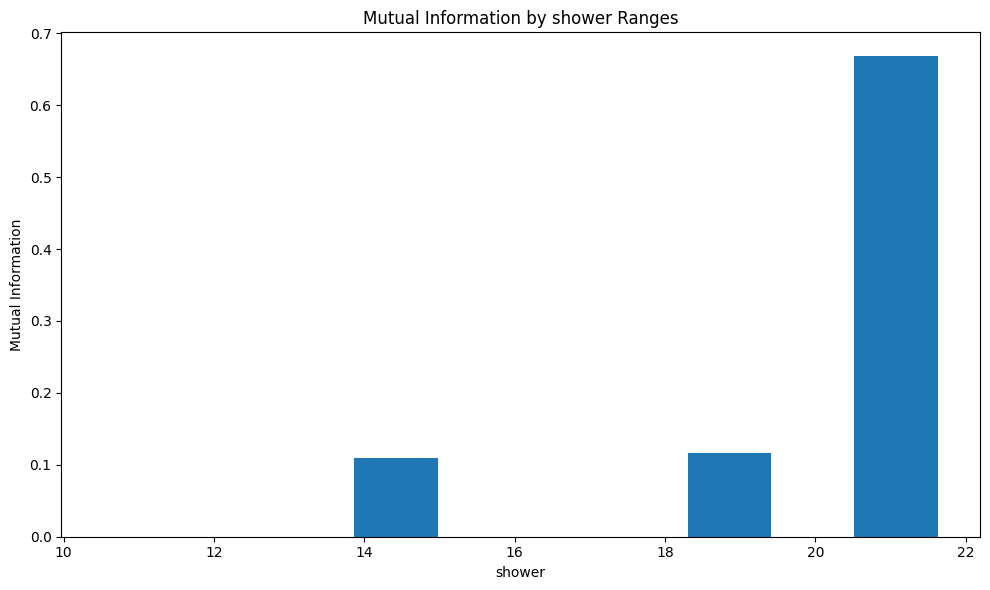

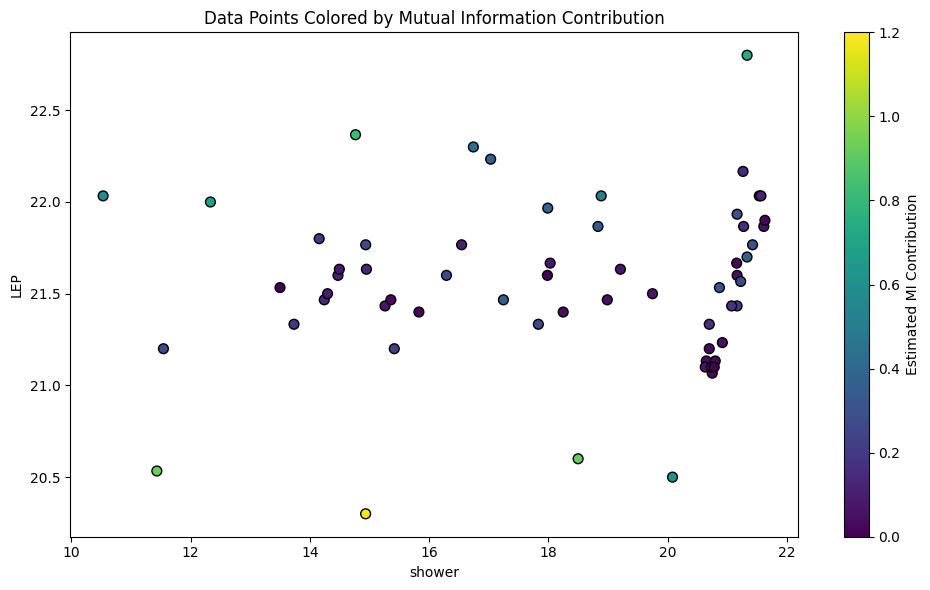

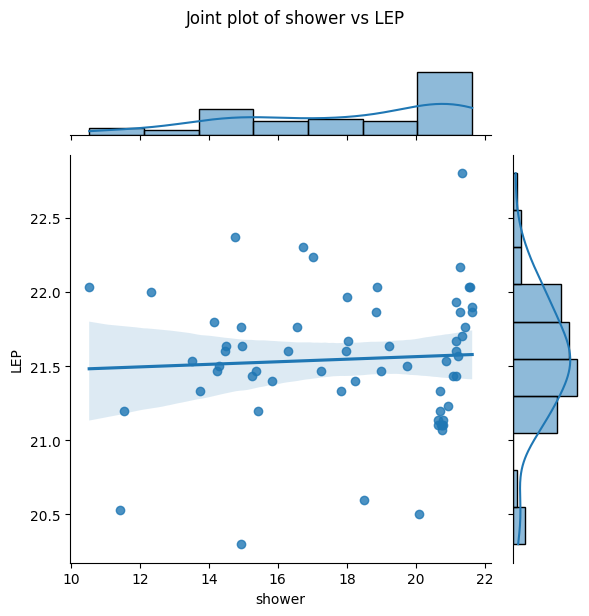

Pearson correlation: 0.0604, p-value: 0.6408
Spearman correlation: 0.1262, p-value: 0.3285
Kendall correlation: 0.0922, p-value: 0.2956
Mutual Information: 0.1022


In [222]:
import stats_two_variables
reload(stats_two_variables)

results = stats_two_variables.calculate_correlations(df, c1, c2)
stats_two_variables.visualize_scatter(df, c1, c2, results)
stats_two_variables.visualize_joint_plot(df, c1, c2)
stats_two_variables.print_correlation_results(results)

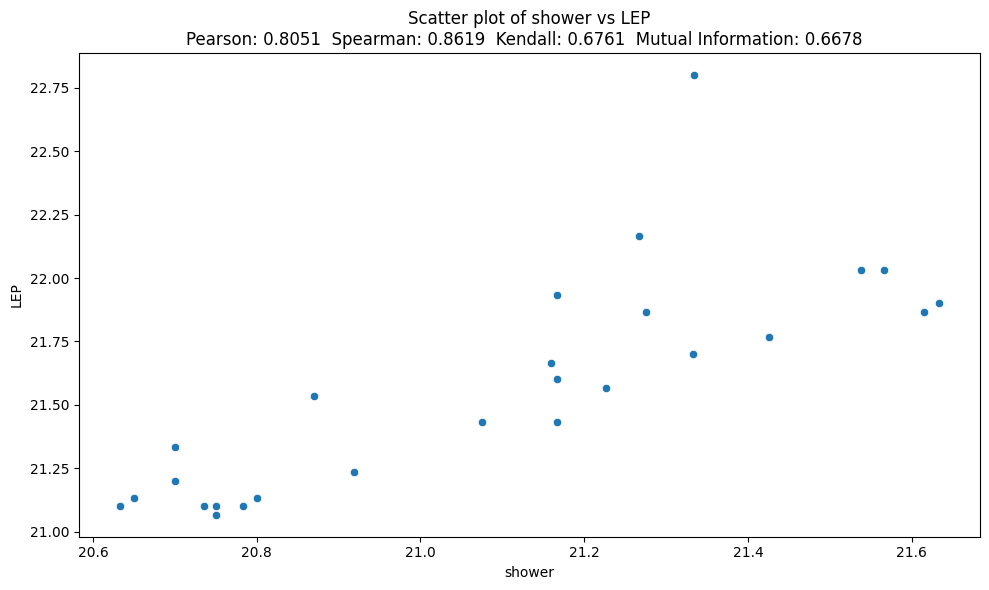

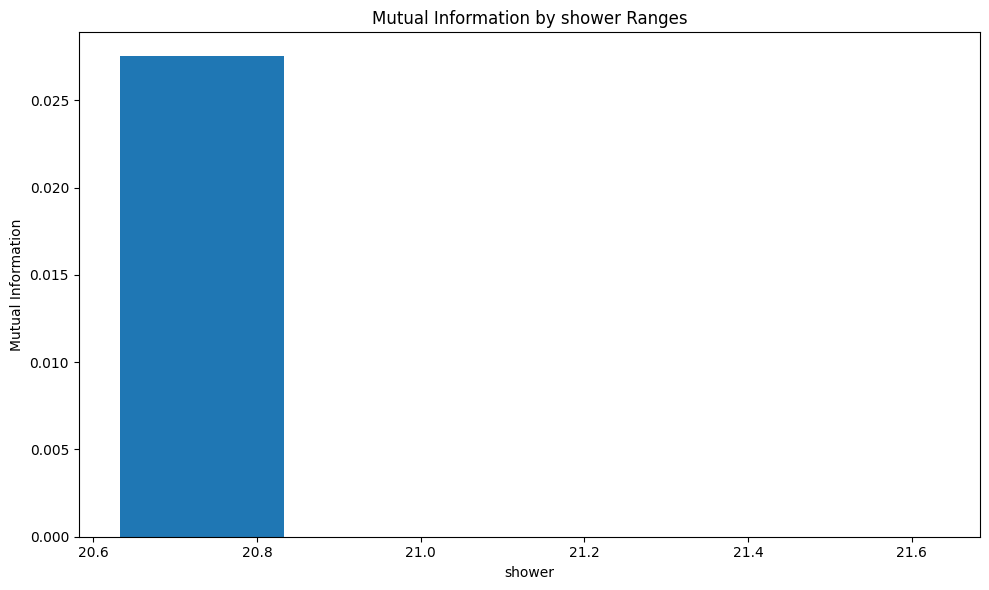

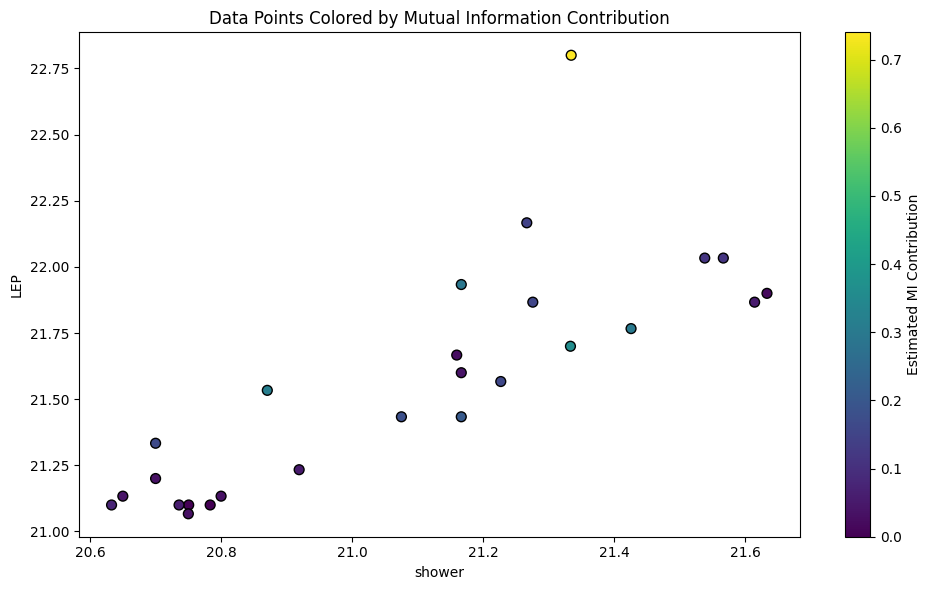

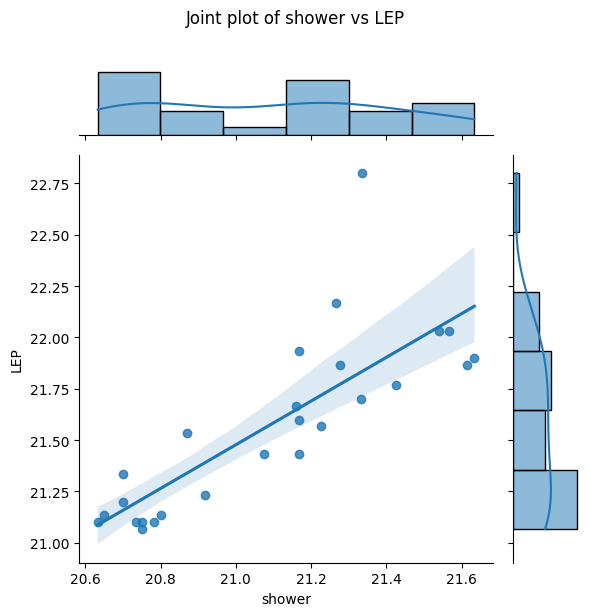

{'Pearson': {'correlation': np.float64(0.8050694273924396),
  'p_value': np.float64(7.067983826442344e-07)},
 'Spearman': {'correlation': np.float64(0.8619458046243965),
  'p_value': np.float64(1.5360984557625803e-08)},
 'Kendall': {'correlation': np.float64(0.6761307172968649),
  'p_value': np.float64(1.9468068129776805e-06)},
 'Mutual Information': {'score': np.float64(0.6678390802848622)}}

In [223]:
# After 8pm
df_after_8 = df[df['shower'] >= 20.25]
results = stats_two_variables.calculate_correlations(df_after_8, c1, c2)
stats_two_variables.visualize_scatter(df_after_8, c1, c2, results)
stats_two_variables.visualize_joint_plot(df_after_8, c1, c2)
results

# Look for horizontal threshold where linear model works better
Works great for shower vs LEP, probbly not for others

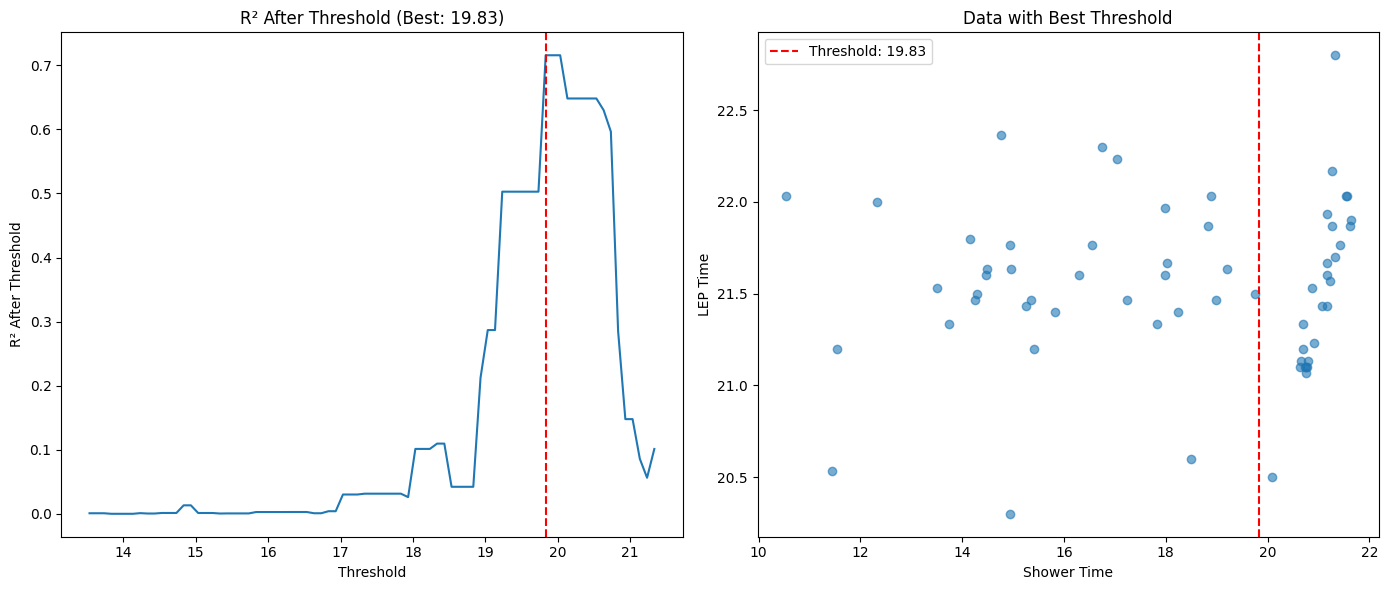

(np.float64(19.8333333333333),
     threshold  points_after  points_before  r2_after  mean_after  std_after
 0   13.533333            57              5  0.001157   21.554971   0.437897
 1   13.633333            57              5  0.001157   21.554971   0.437897
 2   13.733333            57              5  0.001157   21.554971   0.437897
 3   13.833333            56              6  0.000315   21.558929   0.440778
 4   13.933333            56              6  0.000315   21.558929   0.440778
 ..        ...           ...            ...       ...         ...        ...
 74  20.933333            15             47  0.147979   21.851111   0.329953
 75  21.033333            15             47  0.147979   21.851111   0.329953
 76  21.133333            14             48  0.086041   21.880952   0.321384
 77  21.233333             9             53  0.056551   22.014815   0.308765
 78  21.333333             7             55  0.101426   22.014286   0.340801
 
 [79 rows x 6 columns])

In [224]:
import stats_two_variables
reload(stats_two_variables)

X = df[c1].values.reshape(-1, 1)
y = df[c2].values

stats_two_variables.find_optimal_threshold(X, y)

# Machine learning

Outlier removal: removed 6 points (9.7%), R² improved from 0.2630 to 0.4930
Decision Tree Rules:
|--- shower <= 21.25
|   |--- shower <= 19.92
|   |   |--- value: [21.64]
|   |--- shower >  19.92
|   |   |--- value: [21.25]
|--- shower >  21.25
|   |--- shower <= 21.38
|   |   |--- value: [22.28]
|   |--- shower >  21.38
|   |   |--- value: [21.92]



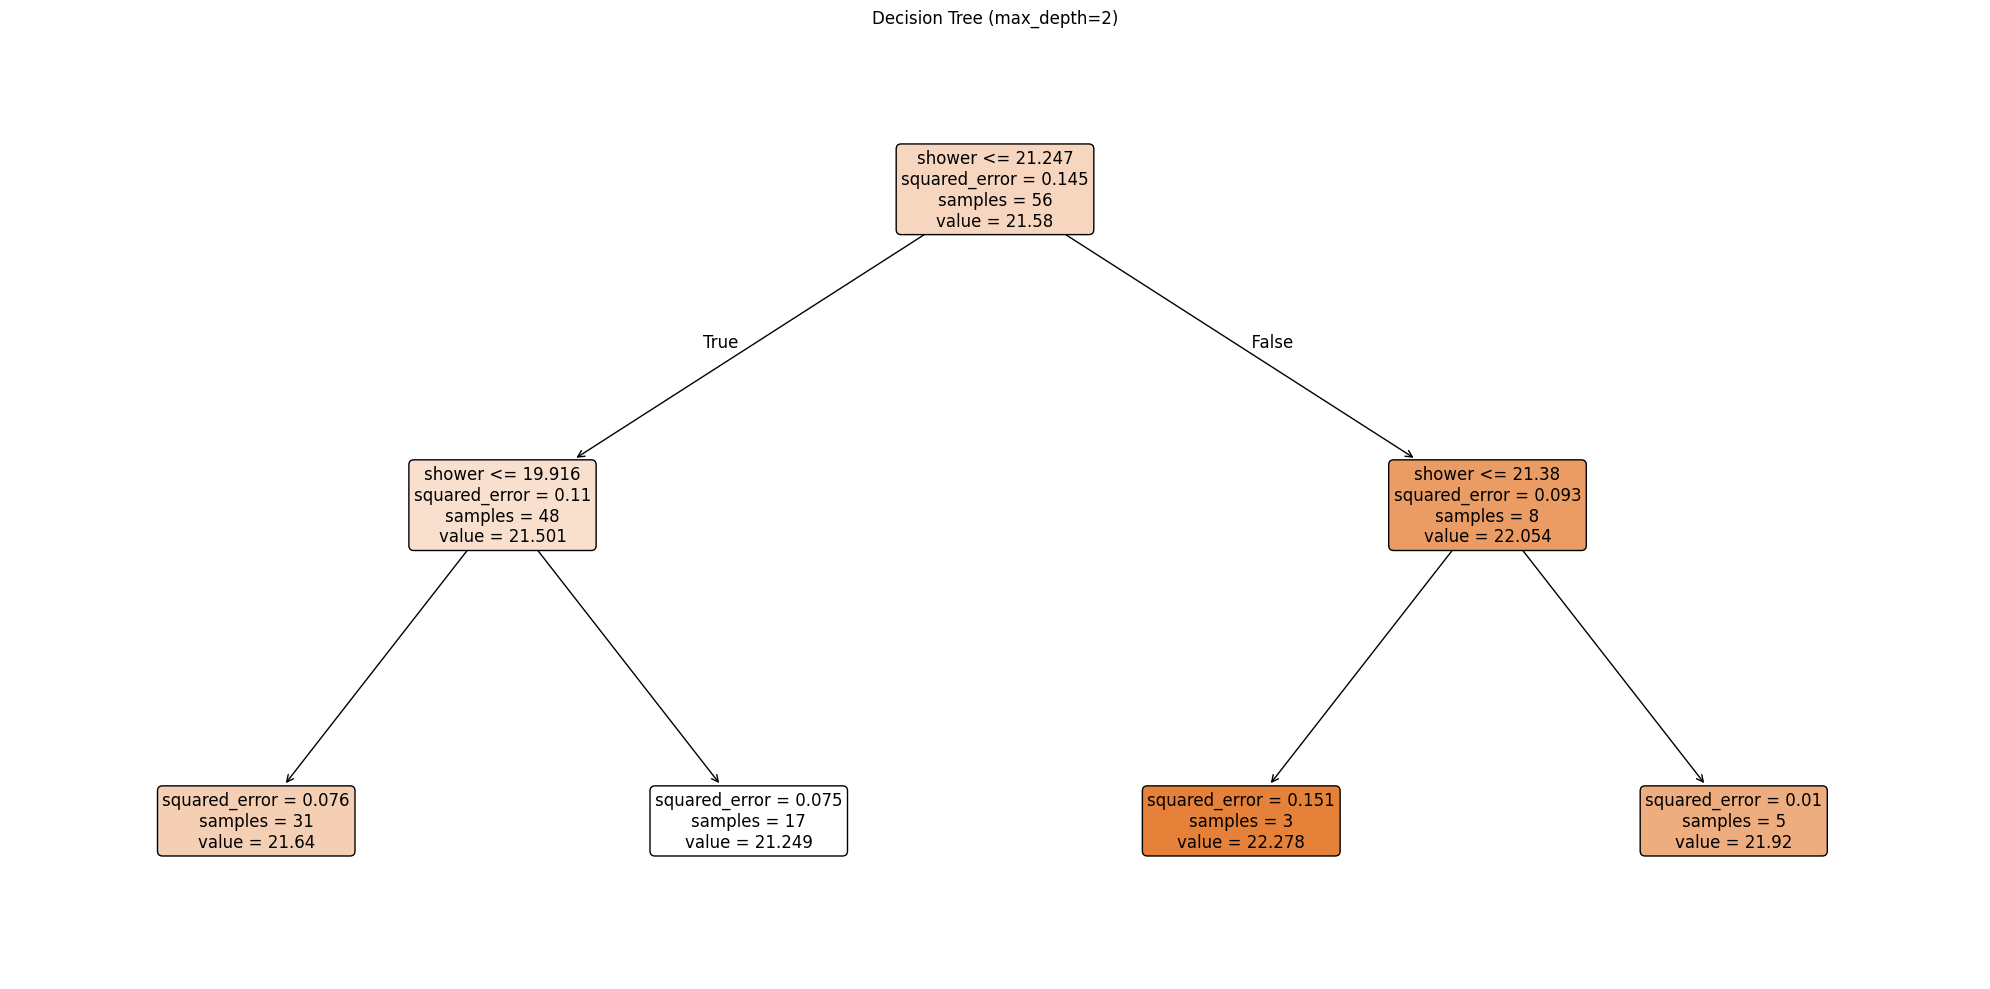

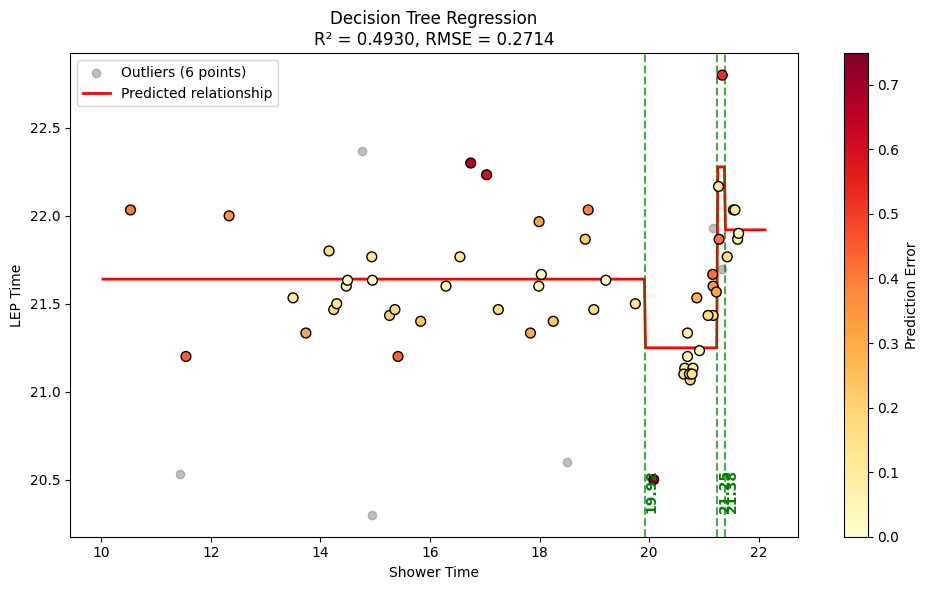

Using 2D GMM clustering on both shower and LEP
Finding GMM subsets for Decision Tree...

--- Decision Tree Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 9 points
    shower range: 16.74 to 19.75 (std=0.95)
    LEP range: 21.47 to 22.30 (std=0.29)
    CV R² Score: 0.1049
    Spearman Correlation (ρ): -0.8333
    Spearman p-value: 0.0053
    Mutual Information: 0.2327
  GMM - Cluster 1 (Index 1):
    Size: 25 points
    shower range: 20.08 to 21.63 (std=0.38)
    LEP range: 20.50 to 22.80 (std=0.47)
    CV R² Score: 0.5848
    Spearman Correlation (ρ): 0.8852
    Spearman p-value: 0.0000
    Mutual Information: 0.7965
  GMM - Cluster 2 (Index 2):
    Size: 22 points
    shower range: 10.53 to 18.25 (std=1.94)
    LEP range: 21.20 to 22.03 (std=0.22)
    CV R² Score: -0.8695 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.2698
    Spearman p-value: 0.2247
    Mutual Information: 0.0000
Decision Tree 

In [237]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_decision_tree_regressor(df, c1, c2, max_depth=2)

Outlier removal: removed 1 points (1.6%), R² improved from 0.8189 to 0.9796


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\skle

Best Gaussian Process Kernel: Matern
Optimized kernel parameters: 0.964**2 * Matern(length_scale=1e-05, nu=1.5)


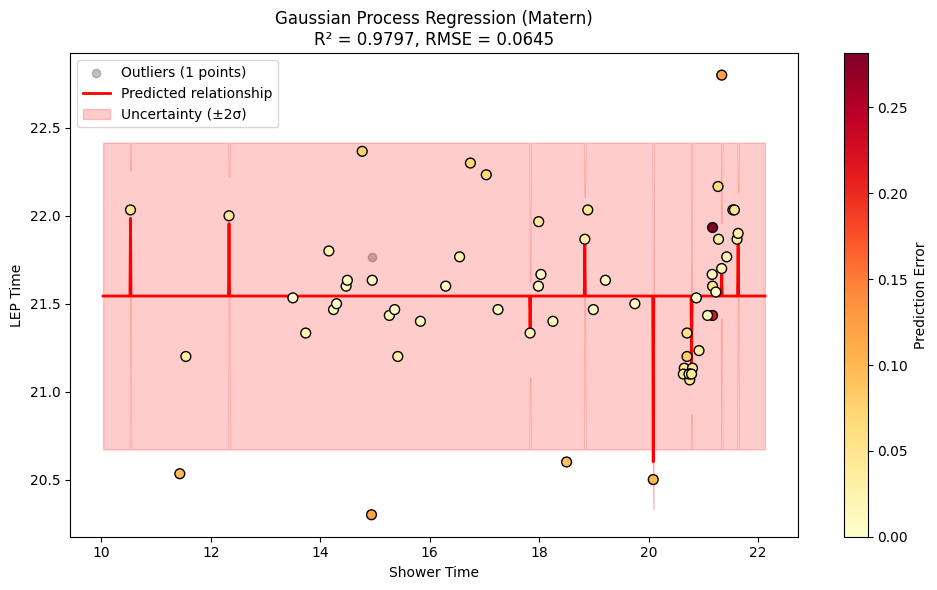

Using 2D GMM clustering on both shower and LEP
Finding GMM subsets for Gaussian Process...

--- Gaussian Process Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 14 points
    shower range: 16.74 to 19.75 (std=0.83)
    LEP range: 20.60 to 22.30 (std=0.42)
    CV R² Score: -0.2135 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.2420
    Spearman p-value: 0.4045
    Mutual Information: 0.0000


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\g

  GMM - Cluster 1 (Index 1):
    Size: 27 points
    shower range: 20.08 to 21.63 (std=0.37)
    LEP range: 20.50 to 22.80 (std=0.46)
    CV R² Score: 0.5200
    Spearman Correlation (ρ): 0.8768
    Spearman p-value: 0.0000
    Mutual Information: 0.7147
  GMM - Cluster 2 (Index 2):
    Size: 20 points
    shower range: 10.53 to 16.55 (std=1.59)
    LEP range: 20.30 to 22.37 (std=0.45)
    CV R² Score: -1.4848 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.0467
    Spearman p-value: 0.8450
    Mutual Information: 0.0055
Gaussian Process Regression Results (Kernel: Matern):
R² score: 0.9797
RMSE: 0.0645
Outliers removed: 1 points (1.6%)


In [226]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_gaussian_process_regressor(df, c1, c2)

Outlier removal: removed 6 points (9.7%), R² improved from 0.1909 to 0.3431
Using 2D GMM clustering on both shower and LEP
Finding GMM subsets for SVR (rbf, C=100.0)...

--- SVR (rbf, C=100.0) Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 16 points
    shower range: 11.54 to 16.55 (std=1.16)
    LEP range: 21.20 to 21.80 (std=0.18)
    CV R² Score: -17.5275 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.1299
    Spearman p-value: 0.6316
    Mutual Information: 0.0000
  GMM - Cluster 1 (Index 1):
    Size: 27 points
    shower range: 20.08 to 21.63 (std=0.37)
    LEP range: 20.50 to 22.80 (std=0.46)
    CV R² Score: 0.4243
    Spearman Correlation (ρ): 0.8768
    Spearman p-value: 0.0000
    Mutual Information: 0.7147
  GMM - Cluster 2 (Index 2):
    Size: 13 points
    shower range: 16.74 to 19.75 (std=0.84)
    LEP range: 20.60 to 22.30 (std=0.42)
    CV R² Score: -1.8677 (Note: Negative R² indic

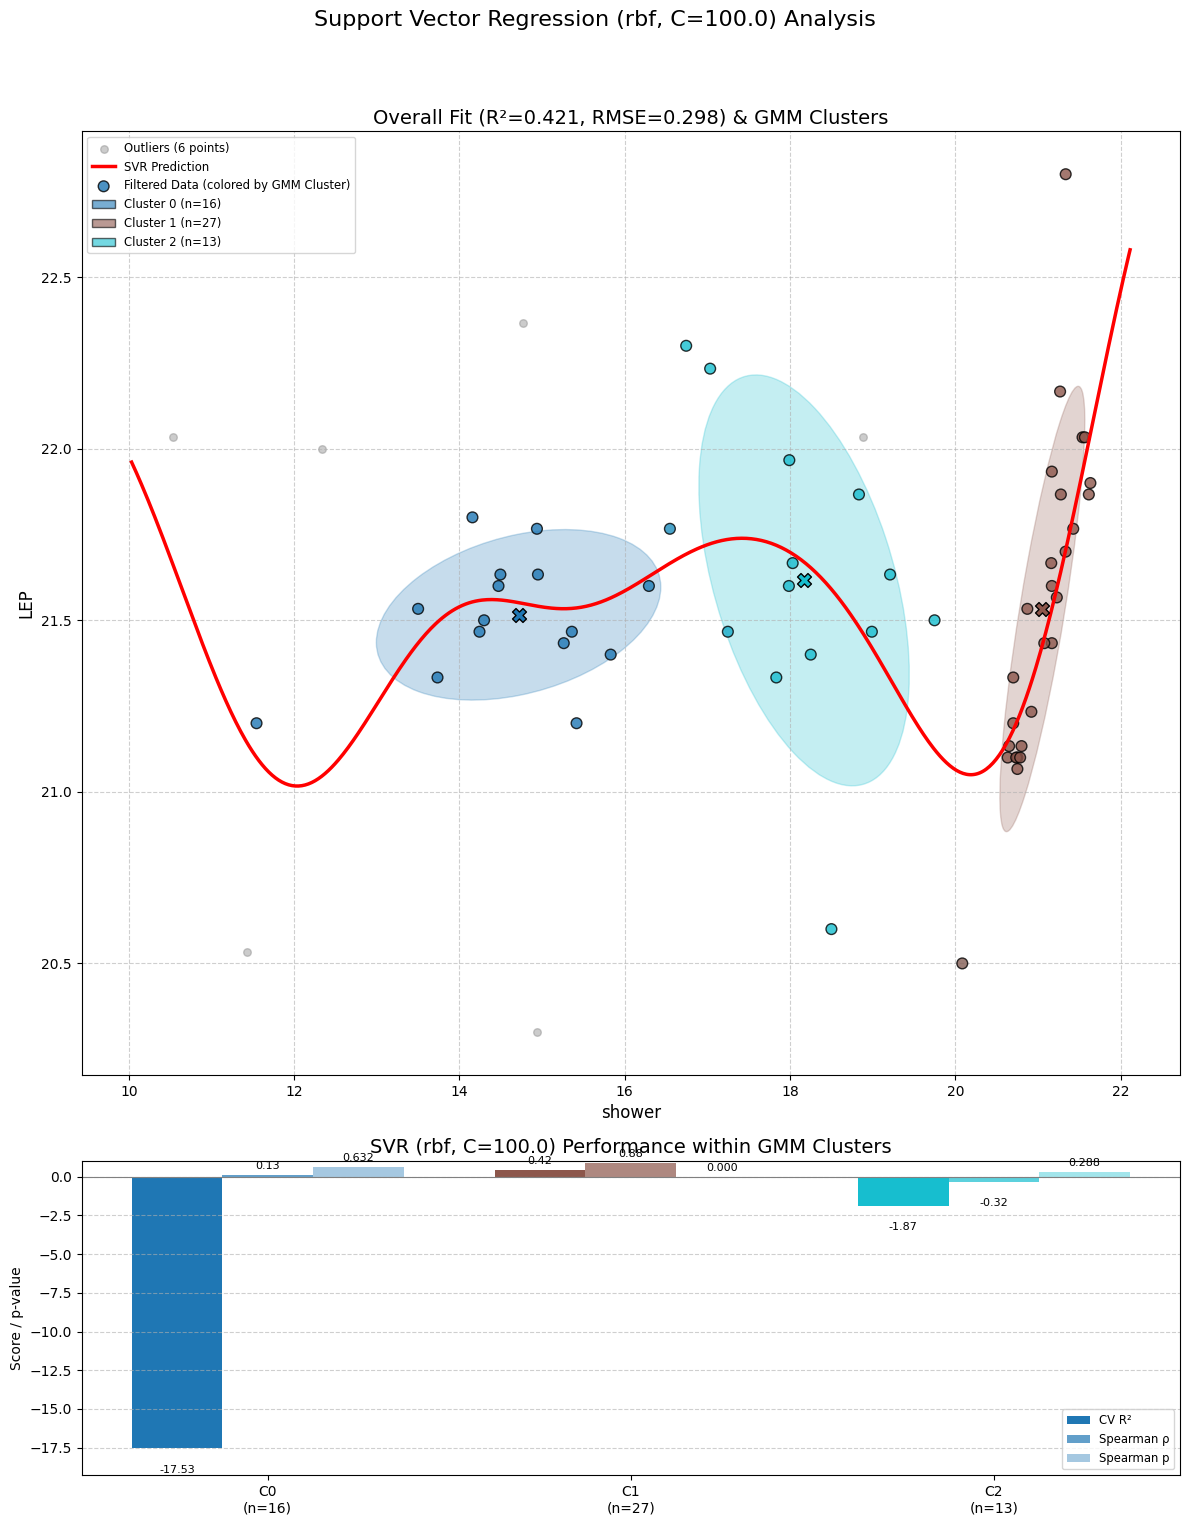


SVR Final Results (Best params: kernel=rbf, C=100.0):
Overall R² (on filtered data): 0.4209
Overall RMSE (on filtered data): 0.2981
Outliers removed: 6 points (9.7%)


In [235]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_svr(df, c1, c2)

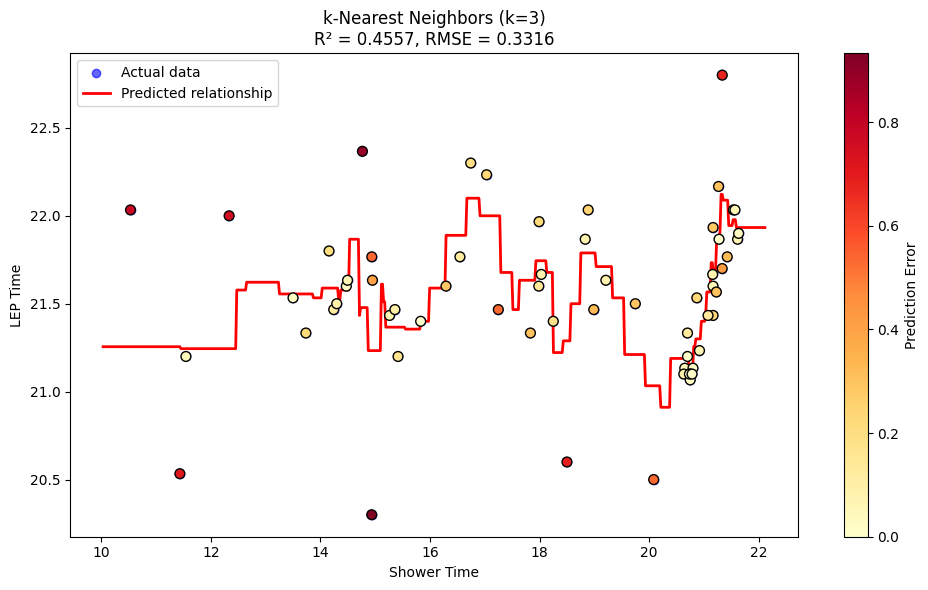

Using 2D GMM clustering on both shower and LEP
Finding GMM subsets for k-NN...

--- k-NN Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 21 points
    shower range: 10.53 to 16.55 (std=1.56)
    LEP range: 20.30 to 22.37 (std=0.45)
    CV R² Score: -2.2604 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.0436
    Spearman p-value: 0.8512
    Mutual Information: 0.0000
  GMM - Cluster 1 (Index 1):
    Size: 27 points
    shower range: 20.08 to 21.63 (std=0.37)
    LEP range: 20.50 to 22.80 (std=0.46)
    CV R² Score: 0.6588
    Spearman Correlation (ρ): 0.8768
    Spearman p-value: 0.0000
    Mutual Information: 0.7147
  GMM - Cluster 2 (Index 2):
    Size: 14 points
    shower range: 16.74 to 19.75 (std=0.83)
    LEP range: 20.60 to 22.30 (std=0.42)
    CV R² Score: -1.2396 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.2420
    Spearman p

In [236]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_knn_regressor(df, c1, c2)




Random Forest Feature Importance: 1.0000


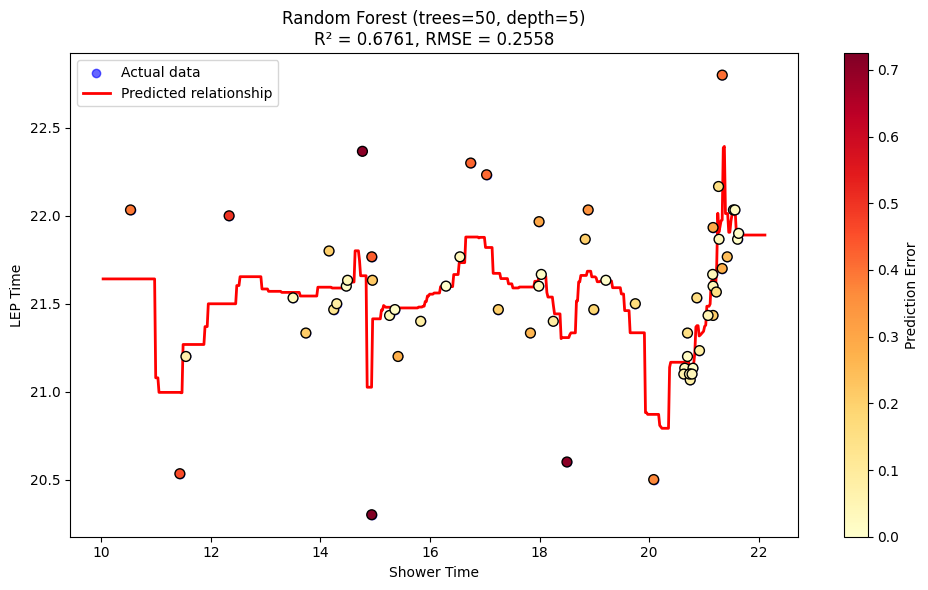

Using 2D GMM clustering on both shower and LEP
Finding GMM subsets for Random Forest...

--- Random Forest Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 21 points
    shower range: 10.53 to 16.55 (std=1.56)
    LEP range: 20.30 to 22.37 (std=0.45)
    CV R² Score: -2.5786 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.0436
    Spearman p-value: 0.8512
    Mutual Information: 0.0000
  GMM - Cluster 1 (Index 1):
    Size: 27 points
    shower range: 20.08 to 21.63 (std=0.37)
    LEP range: 20.50 to 22.80 (std=0.46)
    CV R² Score: 0.5455
    Spearman Correlation (ρ): 0.8768
    Spearman p-value: 0.0000
    Mutual Information: 0.7147
  GMM - Cluster 2 (Index 2):
    Size: 14 points
    shower range: 16.74 to 19.75 (std=0.83)
    LEP range: 20.60 to 22.30 (std=0.42)
    CV R² Score: -0.8671 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.2

In [229]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_random_forest_regressor(df, c1, c2)


# Symbolic representation

In [212]:
from pysr import PySRRegressor

df2 = df.copy().drop(columns=['Diff'])
df2.columns = df2.columns.str.replace(':', '_')
X = df2.drop(columns=['LEP'])
y = df2['LEP']

model = PySRRegressor(niterations=30, progress=True)
model.fit(X, y)


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.020e-01  1.594e+01  y = 21.547
5           2.013e-01  9.148e-04  y = (shower * 0.0086234) + 21.391
7           1.868e-01  3.733e-02  y = (-0.12265 / (shower - 21.837)) + 21.443
11          1.825e-01  5.726e-03  y = (shower * ((-0.11383 / (shower + -11.321)) + 21.589)) ...
                                      / shower
13          1.817e-01  2.367e-03  y = shower * (((-0.20556 / (shower + -11.228)) + 21.415) /...
                                       (shower + -0.15357))
15          1.805e-01  3.327e-03  y = shower * ((((-0.19275 / (shower + -11.243)) + 20.555) ...
                                      / (shower + -0.47157)) - -0.026435)
19          1.801e-01  4.808e-04  y = shower * ((((-0.35897 / (shower + ((shower * 1.1959) -...
                                       24.781))) + 20.743) / (shower + -0.39738)) - -0.020667)
21    

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score  \
	0        0.000000   
	1        0.000915   
	2  >>>>  0.037331   
	3        0.005726   
	4        0.002367   
	5        0.003327   
	6        0.000481   
	7        0.003073   
	8        0.000559   
	
	                                                                                                                                                       equation  \
	0                                                                                                                                                     21.547327   
	1                                                                                                                            (shower * 0.008623369) + 21.391174   
	2                                                                                                             (-0.122652106 / (shower - 21.837122)) + 21.442942   
	3                                                                                       (shower * ((-0.11382682 / (shower + -11.320804)) + 21.588785)) / shower   
	4                                                                       shower * (((-0.20556106 / (shower + -11.228312)) + 21.414558) / (shower + -0.15356755))   
	5                                                       shower * ((((-0.19274908 / (shower + -11.242509)) + 20.55509) / (shower + -0.47156549)) - -0.026435299)   
	6                                 shower * ((((-0.35897353 / (shower + ((shower * 1.1959174) - 24.781065))) + 20.74335) / (shower + -0.397379)) - -0.020667199)   
	7                       (shower * ((((-0.3514824 / ((shower + (shower * 1.2600315)) - 25.531038)) + 20.91777) / (shower + -0.69641)) - -0.0440494)) - 0.9820654   
	8  ((shower * ((((-0.35817614 / ((shower + (shower * 1.240518)) - 25.323694)) + 20.964348) / (shower + -0.8309095)) - -0.05632801)) - 0.93964314) + -0.48845676   
	
	       loss  complexity  
	0  0.201991           1  
	1  0.201253           5  
	2  0.186774           7  
	3  0.182545          11  
	4  0.181683          13  
	5  0.180478          15  
	6  0.180131          19  
	7  0.179027          21  
	8  0.178828          23  
]

In [213]:
import pandas as pd

equation_df = model.equations_
print(equation_df[['equation', 'loss', 'complexity']])


                                                                                                                                                       equation  \
0                                                                                                                                                     21.547327   
1                                                                                                                            (shower * 0.008623369) + 21.391174   
2                                                                                                             (-0.122652106 / (shower - 21.837122)) + 21.442942   
3                                                                                       (shower * ((-0.11382682 / (shower + -11.320804)) + 21.588785)) / shower   
4                                                                       shower * (((-0.20556106 / (shower + -11.228312)) + 21.414558) / (shower + -0.15356755))   
5                     

In [214]:
feature_list = df.columns
mapping = {f'x{i}': name for i, name in enumerate(feature_list)}

import re

def replace_vars(equation, mapping):
    for k, v in mapping.items():
        equation = re.sub(rf'\b{k}\b', v, equation)
    return equation

readable_eqs = [replace_vars(eq, mapping) for eq in model.equations_["equation"]]
readable_eqs



['21.547327',
 '(shower * 0.008623369) + 21.391174',
 '(-0.122652106 / (shower - 21.837122)) + 21.442942',
 '(shower * ((-0.11382682 / (shower + -11.320804)) + 21.588785)) / shower',
 'shower * (((-0.20556106 / (shower + -11.228312)) + 21.414558) / (shower + -0.15356755))',
 'shower * ((((-0.19274908 / (shower + -11.242509)) + 20.55509) / (shower + -0.47156549)) - -0.026435299)',
 'shower * ((((-0.35897353 / (shower + ((shower * 1.1959174) - 24.781065))) + 20.74335) / (shower + -0.397379)) - -0.020667199)',
 '(shower * ((((-0.3514824 / ((shower + (shower * 1.2600315)) - 25.531038)) + 20.91777) / (shower + -0.69641)) - -0.0440494)) - 0.9820654',
 '((shower * ((((-0.35817614 / ((shower + (shower * 1.240518)) - 25.323694)) + 20.964348) / (shower + -0.8309095)) - -0.05632801)) - 0.93964314) + -0.48845676']

⚠️ Skipped equation 9 due to error:
21.547327
x and y must have same first dimension, but have shapes (300,) and (1,)


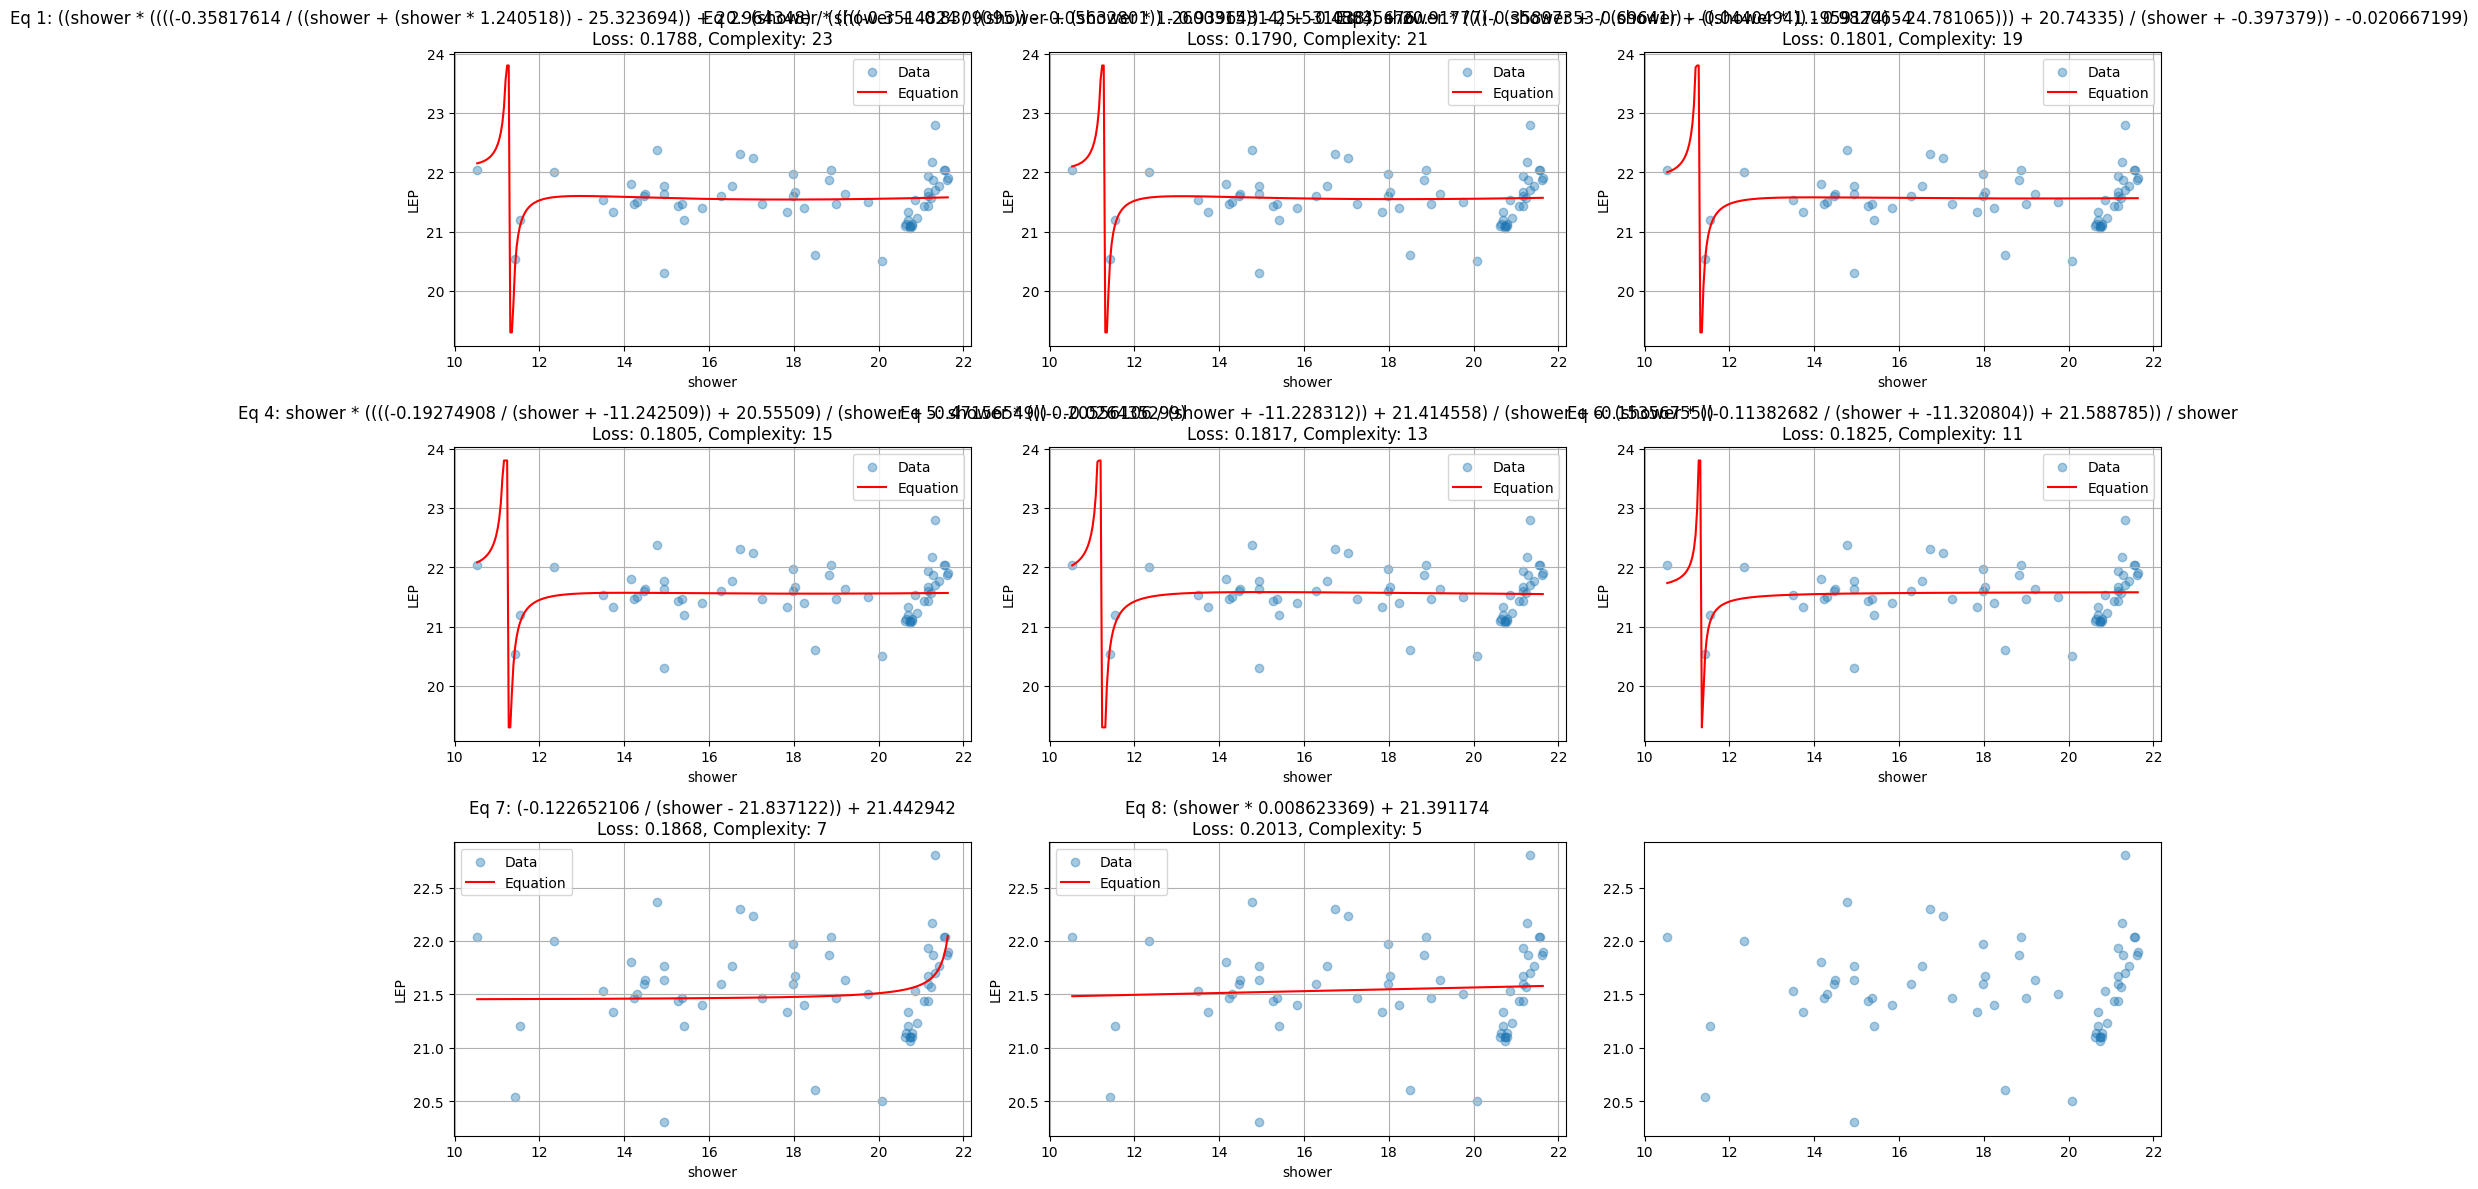

In [218]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
from sympy.utilities.lambdify import lambdify

# Define your feature
feature = X.columns[0]
x_vals = np.linspace(X[feature].min(), X[feature].max(), 300)
x_df = pd.DataFrame({feature: x_vals})

# Define output y range to clip
Y_CLIP_MIN, Y_CLIP_MAX = y.min() - 1, y.max() + 1

# Top 9 equations
top_equations = model.equations_.sort_values("loss").head(9)

x_sym = sp.Symbol(feature)

plt.figure(figsize=(18, 12))
for i, row in enumerate(top_equations.itertuples(), 1):
    try:
        expr = sp.sympify(row.equation)
        func = lambdify(x_sym, expr, modules=["numpy"])
        y_vals = func(x_vals)

        # Handle crazy outputs
        y_vals = np.nan_to_num(y_vals, nan=np.nan, posinf=np.nan, neginf=np.nan)
        y_vals = np.clip(y_vals, Y_CLIP_MIN, Y_CLIP_MAX)

        plt.subplot(3, 3, i)
        plt.scatter(X[feature], y, alpha=0.4, label="Data")
        plt.plot(x_vals, y_vals, color='red', label="Equation")
        plt.title(f"Eq {i}: {row.equation}\nLoss: {row.loss:.4f}, Complexity: {row.complexity}")
        plt.xlabel(feature)
        plt.ylabel("LEP")
        plt.legend()
        plt.grid(True)

    except Exception as e:
        print(f"⚠️ Skipped equation {i} due to error:\n{row.equation}\n{e}")

plt.tight_layout()
plt.show()
